# Sentiment Analysis of Tweets using Neural Networks 

This project aims to train a neural network to detect sentiment from tweets. A common problem in financial markets is to gauge the wider market's sentiment regarding a financial asset. One way to get insight into this, particularly in the cryptocurrency markets, is to train a neural network to detect sentiment from twitter data. This idea was the inspiration for this project. I will begin the project by cleaning the labelled twitter data I downloaded from Kaggle. Following this, I will train the neural network using the package tensorflow. Lastly I will evaluate it's performance on the test data.  

## Dataset Description
First load the data and look at the top rows. Check how many observations there are.

In [458]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random 
from IPython.display import Image

In [459]:
data = pd.read_csv('train.csv')  
print("There are " + str(len(data)) + " rows of data.")
data.head()

There are 27481 rows of data.


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Check to see the counts of positive, negative and neutral.

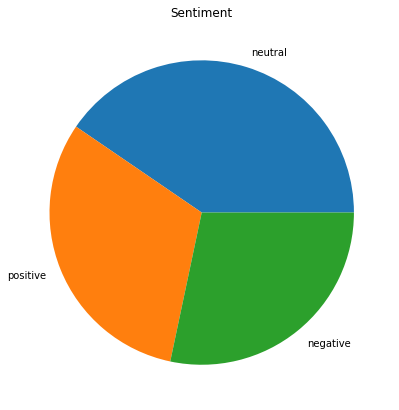

In [460]:
data['sentiment'].value_counts().plot(kind='pie',figsize = (7,7),title = 'Sentiment',ylabel = "")  
plt.title('Sentiment')
plt.show()

Sentiments are roughly even with slighly more as neutral. This seems like a reasonable distribution for sentiments for training.  
## Data Cleaning
### Handle NA Values and Data Types

In [461]:
print(data.isnull().values.any(),data.isnull().values.sum())

True 2


As there are only a small number of null values I will just remove the rows containing them. I also ensure the column with selected_text is loaded correctly as a type string. 

In [462]:
data = data.dropna()  
data.reset_index  
data.astype({"selected_text": str})

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


### Process Labels
For the neural network to be able to process our sentimet labels, I created a new column representing sentiment as an integer. The scheme is described below. 
- Positive = 2 
- Neutral = 1 
- Negative = 0 

In [463]:
data['sentiment_num'] = ""

for index, row in data.iterrows():
    if row['sentiment'] == 'positive': 
        row['sentiment_num'] = 2 
    elif row['sentiment'] == 'negative': 
        row['sentiment_num'] = 0 
    else: 
        row['sentiment_num'] = 1 
data.groupby('sentiment_num').count()

,textID,text,selected_text,sentiment
sentiment_num,,,,
0,7781,7781,7781,7781
1,11117,11117,11117,11117
2,8582,8582,8582,8582


### Split data into train and test set. 
I'm going to perform a 70/30 train/test split. Then using this split I seperate my training/testing sentences/labels out accordingly.

In [464]:
import math as m

training_size = m.floor(0.7 * len(data))

training_sentences = np.array(data['selected_text'][0:training_size])
testing_sentences = data['selected_text'][training_size:]
training_labels = data['sentiment_num'][0:training_size]
testing_labels = data['sentiment_num'][training_size:]

## Tokenization and Word Embeddings 

In order for the neural network to gather meaning from the sentences, we need to convert the sentences to numeric values. At first it may seem to natural to create a numbering scheme for each character. For example take the word 'bear' and assign: 
- b -> 1
- e -> 2 
- a -> 3
- r -> 4 
However, this presents a problem as 'bare' has the same letters and hence the same numbers. It is therefore difficult to interpret sentiment just from the charcters in a string. 

The solution is to create an encoding scheme for the words to create 'tokens'. For example, encode 'I love my dog' as: 
- I -> 1
- Love -> 2
- My -> 3
- Dog -> 4  
Then if we take another sentence, for example 'I love my cat', we only need to encode the word cat. 
- I -> 1
- Love -> 2
- My -> 3
- Cat -> 5  
These sentences have been converted to sequences of numbers [1,2,3,4] and [1,2,3,5]. We can see similarity between these sentences and it is exactly what we would expect as both sentences are expressing love for their pet. 

The concept of embeddings takes this one step further. Embedding takes a word and turns into a vector. Similar words such as man and woman will have a siilar direction and be located close to each other. Likewise words that are dissimilar will have different directions and be located further apart. 


![title](word_embeddings_plot.png)
Source: https://becominghuman.ai/nlp-serverless-deployment-of-word-embeddings-and-retrieving-most-similar-words-using-kmeans-aws-51f129297995 


If we then sum these vectors we will get a new vector. This vector will define the overall direction of the words or the sentiment of the sentence. The neural network then learn the directions which represent positive,negative and neutral.

To be able to handle processing sentences of different lengths, I 'pad' the sentences by appending zero values up to the length of the longest sentence. All of the above is executed in the following code.

Here I set the parameters for this processing.

In [465]:
vocab_size = 10000  # Keeps n most common words
max_length = 100  # Fix the longest sentence to be a maximum of 100 tokens/words long.
trunc_type='post' # Pad the sentences after the last token. 
padding_type='post' # Pad the sentences after the last token. 
oov_tok = "<OOV>" # Fill words not in the word index with <OOV> "Out Of Vocabulary"

This block tokenizes the sentences,converts them to sequences and lastly pads them. It is important here to only tokenize the training sentences so that later we can accurately gauge how the neural network performs out of sample.

In [466]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 


tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") 

# Fit tokenizer only to training sentences
tokenizer.fit_on_texts(training_sentences)


training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Tensorflow takes numpy arrays with float values as inputs. Here I ensure the data is structered accordingly. 

In [467]:
# Ensure data is stored as array with elements of type float
training_padded = np.array(training_padded).astype(np.float32)
training_labels = np.array(training_labels).astype(np.float32)
testing_padded = np.array(testing_padded).astype(np.float32)
testing_labels = np.array(testing_labels).astype(np.float32)  

## Neural Network  

In this section I define the architecture of the neural network.  
![title](NN_Flow_Chart1.png) 
- __Input Layer:__ The input layer has 100 input neurons as 100 was the max length chosen for the sentence sequences. 
- __Embedding Layer:__ This layer converts eahc token/word in these sequences to vectors. With each vector having 30 components. The choice for the number of components is somewhat arbitrary. 30 was chosen after experimenting through trial and error to achieve good accuracy in prediction.  
- __Pooling Layer__: This layer adds up all the vectors outputted from the previous layer.
- __Hidden Layer:__ This hidden layer contains 20 neurons. Similarly to before this number is somewhat arbitrary. More neurons means increased accuracy however there is a diminishing return. There is a trade off between accuracy and time to train the model. 20 seemed to be the smallest amount of neurons without losing significant accuracy in training. The activation function for this layer is the sigmoid function: $$ \sigma = \frac{1}{1+e^{-(\omega x + b)}} $$
- __Output Layer:__ There are 3 output neurons in this layer for each category of sentiment. Each neuron holds a probability of it being the correct layer. Naturally the neuron with the highest probability is taken to be the final output. As this is a multiclassification model I chose the activation fucntion for the output layer to be the Softmax function: $$ \sigma (z)_i = \frac{e^{z_i}}{\sum_{j=1}^{N} e^{z_j}} $$ 


__Sparse Categorical Cross Entropy Loss Function__ 
As this is a multiclassification problem we need a loss function for that. The sparse in the title just refers to output being scalar values. The sparse categorical cross cntropy works exactly the same as the regular categorical cross entropy function. The function is defined below: $$ Loss = \ - \sum_{i=1}^{C} y_ilog\hat{y_i} $$ 
- C = Output Size. 
- $\hat{y_i}$ = i-th scalar value of the model output. 
- $y_i$ = corresponding target value.

__Adam Optimization Function__  
The 'Adam' optimization function is an adapted version of the stochastic gradient descent algorithm. Adam adapts the learning parameter rate by using the averages of both the first and second moments of the gradient. The algorithm calculates an exponential moving average of the gradient and the squared gradient. The key advantage for Adam is that it is faster than stochastic gradient descent. See the below for a comparison against other optimization algorithms.

![title](adam_comparison.png)
Source: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ 

## Fit the Model

In [480]:
import tensorflow as tf

embedding_dim = 30

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(20, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
]) 
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 100, 30)           300000    
                                                                 
 global_average_pooling1d_50  (None, 30)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_98 (Dense)            (None, 20)                620       
                                                                 
 dense_99 (Dense)            (None, 3)                 63        
                                                                 
Total params: 300,683
Trainable params: 300,683
Non-trainable params: 0
_________________________________________________________________


Next we fit the model. To start we will trial 30 epochs and then evaluate the results. 

In [481]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[tensorboard_callback])

Epoch 1/30
602/602 - 5s - loss: 1.0418 - accuracy: 0.4770 - val_loss: 0.9402 - val_accuracy: 0.6015 - 5s/epoch - 9ms/step
Epoch 2/30
602/602 - 3s - loss: 0.8795 - accuracy: 0.6028 - val_loss: 0.8367 - val_accuracy: 0.6340 - 3s/epoch - 5ms/step
Epoch 3/30
602/602 - 3s - loss: 0.8133 - accuracy: 0.6223 - val_loss: 0.7987 - val_accuracy: 0.6543 - 3s/epoch - 4ms/step
Epoch 4/30
602/602 - 3s - loss: 0.7665 - accuracy: 0.6512 - val_loss: 0.7572 - val_accuracy: 0.6644 - 3s/epoch - 4ms/step
Epoch 5/30
602/602 - 3s - loss: 0.7153 - accuracy: 0.6880 - val_loss: 0.7126 - val_accuracy: 0.7234 - 3s/epoch - 4ms/step
Epoch 6/30
602/602 - 4s - loss: 0.6567 - accuracy: 0.7525 - val_loss: 0.6609 - val_accuracy: 0.7741 - 4s/epoch - 7ms/step
Epoch 7/30
602/602 - 3s - loss: 0.5910 - accuracy: 0.8047 - val_loss: 0.6102 - val_accuracy: 0.8024 - 3s/epoch - 5ms/step
Epoch 8/30
602/602 - 3s - loss: 0.5294 - accuracy: 0.8299 - val_loss: 0.5683 - val_accuracy: 0.8167 - 3s/epoch - 4ms/step
Epoch 9/30
602/602 - 3s 

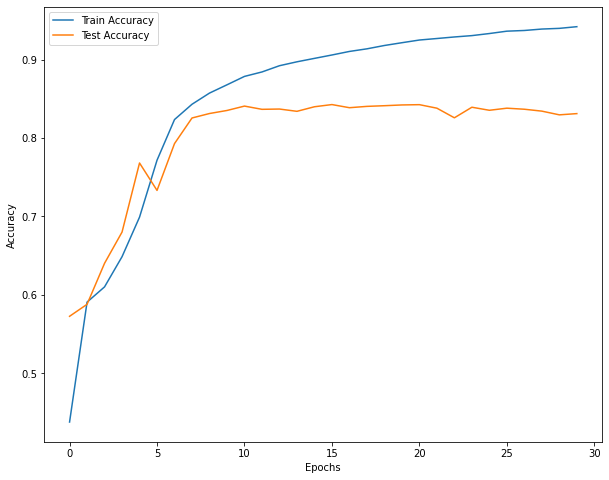

In [474]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

Based on the above plot, after approximately 7 epochs we begin to model the nuances of the training set. After this point we do not gain any additional accuracy in the testing set. For those reasons I will retrain the model with 7 epochs for final validation to avoid overfitting.

In [475]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(60, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])  

#### REMEMBER SECTION ON OPTIMZER
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(training_padded, training_labels, epochs=7, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[tensorboard_callback])

Epoch 1/7
602/602 - 5s - loss: 1.0289 - accuracy: 0.4799 - val_loss: 0.8934 - val_accuracy: 0.5987 - 5s/epoch - 9ms/step
Epoch 2/7
602/602 - 3s - loss: 0.8531 - accuracy: 0.6013 - val_loss: 0.8286 - val_accuracy: 0.6098 - 3s/epoch - 5ms/step
Epoch 3/7
602/602 - 3s - loss: 0.7969 - accuracy: 0.6330 - val_loss: 0.7818 - val_accuracy: 0.6367 - 3s/epoch - 4ms/step
Epoch 4/7
602/602 - 3s - loss: 0.7396 - accuracy: 0.6811 - val_loss: 0.7324 - val_accuracy: 0.7221 - 3s/epoch - 4ms/step
Epoch 5/7
602/602 - 3s - loss: 0.6654 - accuracy: 0.7557 - val_loss: 0.6632 - val_accuracy: 0.7869 - 3s/epoch - 4ms/step
Epoch 6/7
602/602 - 3s - loss: 0.5796 - accuracy: 0.8123 - val_loss: 0.5950 - val_accuracy: 0.8026 - 3s/epoch - 4ms/step
Epoch 7/7
602/602 - 3s - loss: 0.5045 - accuracy: 0.8378 - val_loss: 0.5461 - val_accuracy: 0.8193 - 3s/epoch - 4ms/step


### Results

In [476]:
from sklearn.metrics import confusion_matrix 
predictions = model.predict(testing_padded)
sentiment_pred = [np.argmax(predictions[x]) for x in range(len(testing_padded))]

81.93


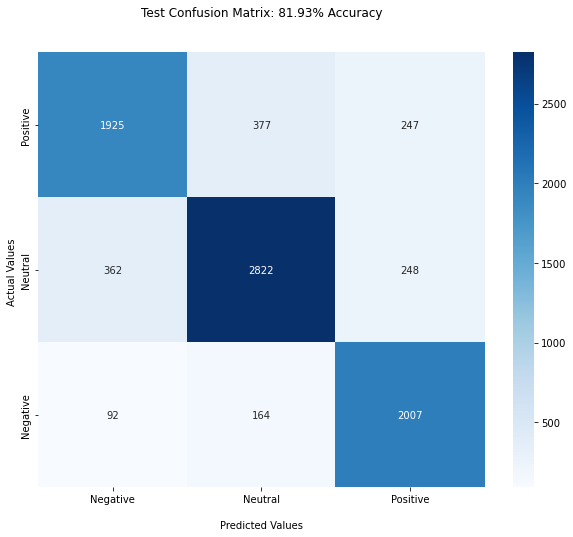

In [477]:
cf_matrix = confusion_matrix(sentiment_pred,testing_labels) 
 
correct = np.trace(cf_matrix) 
percent_correct = round((correct/len(testing_labels))*100,2)
print(percent_correct)    

import seaborn as sns 
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10,8
x_labels = ['Negative','Neutral','Positive']
y_labels = ['Positive','Neutral','Negative']
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g',xticklabels=x_labels,yticklabels=y_labels)

ax.set_title('Test Confusion Matrix: ' + str(percent_correct) + '% Accuracy\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')



## Display the visualization of the Confusion Matrix.
plt.show()

## Conclusions 
The model was able to predict sentiment from tweets with nearly 82% accuracy. In my view, for a relatively simple neural network, this is really impressive. It would be interesting to get alot more data, add more layers to the model and retrain to see if this percent could get even higher.  